In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

In [2]:
data = pd.read_csv('wines_2012.csv', delimiter=',')
data.head()

,judge,flight,wine,score,wine.amer,judge.amer
0,Jean-M Cardebat,white,A1,10.0,1,0
1,Jean-M Cardebat,white,B1,13.0,1,0
2,Jean-M Cardebat,white,C1,14.0,0,0
3,Jean-M Cardebat,white,D1,15.0,0,0
4,Jean-M Cardebat,white,E1,8.0,1,0


In [3]:
data['judge_num'] = pd.factorize(data['judge'])[0] + 1
data['wine_num'] = pd.factorize(data['wine'])[0] + 1

# Normalizing the score
mean_score = data['score'].mean()
std_score = data['score'].std()
data['score_est'] = (data['score'] - mean_score) / std_score

# Display the resulting DataFrame
data.head()

,judge,flight,wine,score,wine.amer,judge.amer,judge_num,wine_num,score_est
0,Jean-M Cardebat,white,A1,10.0,1,0,1,1,-1.576604
1,Jean-M Cardebat,white,B1,13.0,1,0,1,2,-0.450458
2,Jean-M Cardebat,white,C1,14.0,0,0,1,3,-0.075076
3,Jean-M Cardebat,white,D1,15.0,0,0,1,4,0.300306
4,Jean-M Cardebat,white,E1,8.0,1,0,1,5,-2.327368


In [4]:
n_judges = len(data['judge'].unique())
n_wines = len(data['wine'].unique())
n_scores = len(data)

wine_data_list = {
    'n_judges': n_judges,
    'n_wines': n_wines,
    'N': n_scores,
}

print(wine_data_list)

{'n_judges': 9, 'n_wines': 20, 'N': 180}


In [5]:
wine_data_list['S'] = data['score_est'].values
wine_data_list['wine'] = data['wine_num'].values
wine_data_list['judge'] = data['judge_num'].values

In [6]:
n_judges = wine_data_list['n_judges']
n_wines = wine_data_list['n_wines']
N = wine_data_list['N']
S = wine_data_list['S']
wine = wine_data_list['wine']
judge = wine_data_list['judge']

with pm.Model() as wine_model_1:
    # Parameters
    Q = pm.Normal('Q', mu=0, sigma=1, shape=n_wines)
    sigma = pm.Exponential('sigma', lam=1)

    # Transformed parameters
    media_score = Q[wine-1] # Python is 0-indexed

    # Model
    S_observed = pm.Normal('S', mu=media_score, sigma=sigma, observed=S)

In [7]:
with wine_model_1:
    trace = pm.sample(
        draws=2000,       # Number of sampling iterations
        tune=1000,        # Number of warmup iterations
        chains=4,         # Number of chains
        cores=4,          # Number of parallel chains
        target_accept=0.9 # Adjust acceptance rate to affect step size
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Q, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 23 seconds.


In [8]:
az.summary(trace, var_names=["Q", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Q[0],0.137,0.323,-0.458,0.752,0.003,0.004,15941.0,5789.0,1.0
Q[1],0.274,0.313,-0.315,0.859,0.003,0.003,13834.0,6036.0,1.0
Q[2],-0.124,0.317,-0.706,0.467,0.003,0.003,14637.0,6101.0,1.0
Q[3],0.290,0.321,-0.321,0.885,0.003,0.003,12535.0,6514.0,1.0
Q[4],0.084,0.314,-0.518,0.661,0.003,0.004,14652.0,5464.0,1.0
Q[5],-0.009,0.315,-0.612,0.571,0.003,0.004,14250.0,6664.0,1.0
Q[6],-0.108,0.315,-0.730,0.456,0.003,0.004,15393.0,6358.0,1.0
Q[7],-0.218,0.319,-0.828,0.361,0.003,0.003,14003.0,6184.0,1.0
Q[8],-0.143,0.306,-0.701,0.443,0.003,0.004,13738.0,5749.0,1.0
Q[9],-0.165,0.317,-0.771,0.422,0.003,0.003,15515.0,6109.0,1.0


In [9]:
summary_df = az.summary(trace, var_names=["Q", "sigma"])
summary_df = summary_df[~summary_df.index.str.contains("lp__")]
summary_df = summary_df[['mean', 'sd', 'hdi_3%', 'hdi_97%', 'r_hat', 'ess_bulk', 'ess_tail']]
summary_df.columns = ['mean', 'sd', 'q3', 'q97', 'rhat', 'ess_bulk', 'ess_tail']
summary_df = summary_df.round(5)
print(summary_df)


        mean     sd     q3    q97  rhat  ess_bulk  ess_tail
Q[0]   0.137  0.323 -0.458  0.752   1.0   15941.0    5789.0
Q[1]   0.274  0.313 -0.315  0.859   1.0   13834.0    6036.0
Q[2]  -0.124  0.317 -0.706  0.467   1.0   14637.0    6101.0
Q[3]   0.290  0.321 -0.321  0.885   1.0   12535.0    6514.0
Q[4]   0.084  0.314 -0.518  0.661   1.0   14652.0    5464.0
Q[5]  -0.009  0.315 -0.612  0.571   1.0   14250.0    6664.0
Q[6]  -0.108  0.315 -0.730  0.456   1.0   15393.0    6358.0
Q[7]  -0.218  0.319 -0.828  0.361   1.0   14003.0    6184.0
Q[8]  -0.143  0.306 -0.701  0.443   1.0   13738.0    5749.0
Q[9]  -0.165  0.317 -0.771  0.422   1.0   15515.0    6109.0
Q[10]  0.105  0.312 -0.526  0.655   1.0   14409.0    6138.0
Q[11]  0.559  0.320 -0.053  1.148   1.0   14208.0    6172.0
Q[12] -0.367  0.319 -0.941  0.246   1.0   13201.0    6043.0
Q[13]  0.267  0.316 -0.295  0.891   1.0   15490.0    6575.0
Q[14]  0.120  0.316 -0.471  0.714   1.0   12896.0    5712.0
Q[15] -0.027  0.318 -0.613  0.586   1.0 

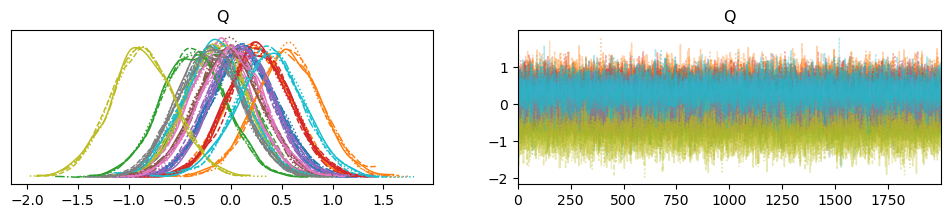

In [10]:
Q_chain1 = trace.posterior['Q']
az.plot_trace(Q_chain1)
plt.show()

In [11]:
import graphviz
from pymc import model_to_graphviz
import os
os.environ["PATH"] += os.pathsep + 'c:\Program Files\Graphviz/bin/'

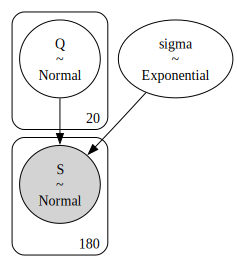

In [12]:
model_to_graphviz(wine_model_1)

Extendiendo el modelo de variable latente

In [13]:
wine_data_list['n_origins'] = len(data['wine.amer'].unique())
wine_data_list['origins'] = data['wine.amer'].values

n_origins = wine_data_list['n_origins']
origin = wine_data_list['origins']

In [14]:
with pm.Model() as wine_model_2:
    # Parameters
    Q = pm.Normal('Q', mu=0, sigma=1, shape=n_wines)
    O = pm.Normal('O', mu=0, sigma=1, shape=n_origins)
    sigma = pm.Exponential('sigma', lam=1)

    # Transformed parameters
    media_score = Q[wine-1] + O[origin-1] # Python is 0-indexed

    # Model
    S_observed = pm.Normal('S', mu=media_score, sigma=sigma, observed=S)

    trace_2 = pm.sample(
        draws=2000,       # Number of sampling iterations
        tune=1000,        # Number of warmup iterations
        chains=4,         # Number of chains
        cores=4,          # Number of parallel chains
        target_accept=0.9 # Adjust acceptance rate to affect step size
    )
    
    dif_origen = pm.Deterministic('dif_origen', O[0] - O[1])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Q, O, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 25 seconds.


In [15]:
az.summary(trace_2, var_names=["O", "Q", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
O[0],-0.068,0.289,-0.602,0.488,0.006,0.004,2248.0,3393.0,1.0
O[1],0.108,0.349,-0.548,0.754,0.007,0.005,2681.0,3783.0,1.0
Q[0],0.201,0.410,-0.573,0.961,0.007,0.005,3770.0,5443.0,1.0
Q[1],0.327,0.408,-0.468,1.062,0.007,0.005,3808.0,4949.0,1.0
Q[2],-0.221,0.442,-1.052,0.610,0.007,0.005,4003.0,5708.0,1.0
Q[3],0.194,0.441,-0.636,1.019,0.007,0.005,3819.0,5157.0,1.0
Q[4],0.147,0.416,-0.640,0.914,0.007,0.005,3891.0,4613.0,1.0
Q[5],0.048,0.409,-0.711,0.815,0.007,0.005,3789.0,5212.0,1.0
Q[6],-0.048,0.408,-0.864,0.668,0.006,0.005,4006.0,4614.0,1.0
Q[7],-0.318,0.444,-1.152,0.514,0.007,0.005,3716.0,5579.0,1.0


In [16]:
summary_wm2 = az.summary(trace_2, var_names=["O", "Q", "sigma"])
summary_wm2 = summary_wm2[~summary_wm2.index.str.contains("lp__")]
summary_wm2 = summary_wm2[['mean', 'sd', 'hdi_3%', 'hdi_97%', 'r_hat', 'ess_bulk', 'ess_tail']]
summary_wm2.columns = ['mean', 'sd', 'q3', 'q97', 'rhat', 'ess_bulk', 'ess_tail']
summary_wm2 = summary_wm2.round(5)
print(summary_wm2)

        mean     sd     q3    q97  rhat  ess_bulk  ess_tail
O[0]  -0.068  0.289 -0.602  0.488   1.0    2248.0    3393.0
O[1]   0.108  0.349 -0.548  0.754   1.0    2681.0    3783.0
Q[0]   0.201  0.410 -0.573  0.961   1.0    3770.0    5443.0
Q[1]   0.327  0.408 -0.468  1.062   1.0    3808.0    4949.0
Q[2]  -0.221  0.442 -1.052  0.610   1.0    4003.0    5708.0
Q[3]   0.194  0.441 -0.636  1.019   1.0    3819.0    5157.0
Q[4]   0.147  0.416 -0.640  0.914   1.0    3891.0    4613.0
Q[5]   0.048  0.409 -0.711  0.815   1.0    3789.0    5212.0
Q[6]  -0.048  0.408 -0.864  0.668   1.0    4006.0    4614.0
Q[7]  -0.318  0.444 -1.152  0.514   1.0    3716.0    5579.0
Q[8]  -0.088  0.408 -0.826  0.705   1.0    4006.0    5177.0
Q[9]  -0.257  0.438 -1.051  0.600   1.0    3903.0    4993.0
Q[10]  0.001  0.448 -0.851  0.842   1.0    4043.0    5079.0
Q[11]  0.458  0.446 -0.403  1.280   1.0    4156.0    5598.0
Q[12] -0.313  0.405 -1.073  0.410   1.0    3891.0    5092.0
Q[13]  0.331  0.406 -0.421  1.107   1.0 

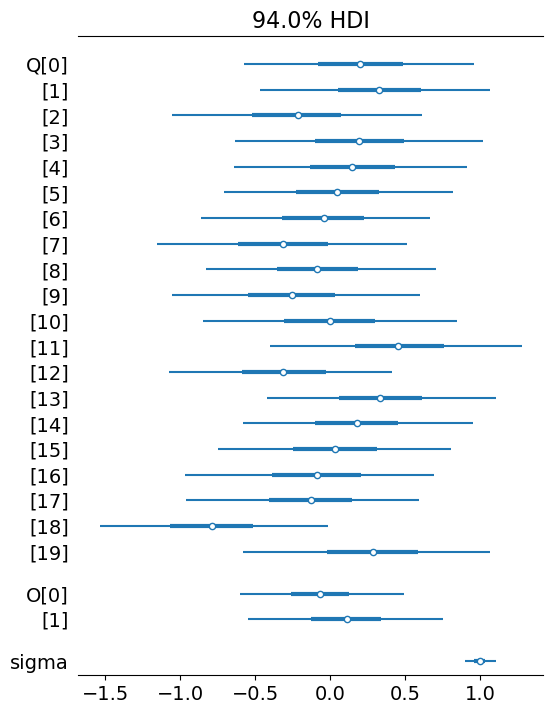

In [17]:
az.plot_forest(trace_2, var_names=("Q", "O", "sigma"), combined=True)
plt.show()

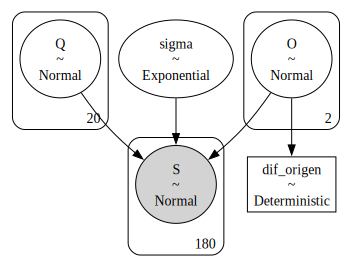

In [18]:
model_to_graphviz(wine_model_2)

Agregando H y D

In [19]:
with pm.Model() as wine_model_3:
    # Parameters
    Q = pm.Normal('Q', mu=0, sigma=1, shape=n_wines)
    O = pm.Normal('O', mu=0, sigma=1, shape=n_origins)
    H = pm.Normal('H', mu=0, sigma=1, shape=n_judges)
    D = pm.HalfNormal('D', sigma=1, shape=n_judges)
    sigma = pm.Exponential('sigma', lam=1)

    # Transformations: media_score
    media_score = (Q[wine-1] + O[origin-1] - H[judge-1]) * D[judge-1]
                   
    # Model
    S_observed = pm.Normal('S', mu=media_score, sigma=sigma, observed=S)

    # Generated quantities
    dif_origen = pm.Deterministic('dif_origen', O[0] - O[1])

    # Sampling
    trace_3 = pm.sample(
        draws=2000,
        tune=1000,
        chains=4,
        cores=4,
        target_accept=0.9
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Q, O, H, D, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 35 seconds.


In [20]:
az.summary(trace_3, var_names=["O", "Q", "H", "D", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
O[0],-0.116,0.434,-0.912,0.695,0.007,0.005,4074.0,5350.0,1.0
O[1],0.192,0.487,-0.723,1.106,0.008,0.006,3606.0,4910.0,1.0
Q[0],0.371,0.554,-0.728,1.361,0.007,0.006,6030.0,5774.0,1.0
Q[1],0.502,0.537,-0.511,1.507,0.007,0.005,6226.0,5902.0,1.0
Q[2],-0.464,0.563,-1.504,0.614,0.007,0.006,6076.0,5763.0,1.0
Q[3],0.224,0.604,-0.852,1.417,0.008,0.006,5121.0,5755.0,1.0
Q[4],0.281,0.546,-0.788,1.287,0.007,0.006,6632.0,5895.0,1.0
Q[5],0.188,0.544,-0.804,1.265,0.007,0.005,6089.0,5807.0,1.0
Q[6],0.060,0.544,-0.901,1.135,0.007,0.006,6510.0,5914.0,1.0
Q[7],-0.528,0.570,-1.569,0.574,0.008,0.006,5734.0,6045.0,1.0


In [21]:
summary_wm3 = az.summary(trace_3, var_names=["O", "Q", "H", "D", "sigma"])
summary_wm3 = summary_wm3[~summary_wm3.index.str.contains("lp__")]
summary_wm3 = summary_wm3[['mean', 'sd', 'hdi_3%', 'hdi_97%', 'r_hat', 'ess_bulk', 'ess_tail']]
summary_wm3.columns = ['mean', 'sd', 'q3', 'q97', 'rhat', 'ess_bulk', 'ess_tail']
summary_wm3 = summary_wm3.round(5)
print(summary_wm3)

        mean     sd     q3    q97  rhat  ess_bulk  ess_tail
O[0]  -0.116  0.434 -0.912  0.695   1.0    4074.0    5350.0
O[1]   0.192  0.487 -0.723  1.106   1.0    3606.0    4910.0
Q[0]   0.371  0.554 -0.728  1.361   1.0    6030.0    5774.0
Q[1]   0.502  0.537 -0.511  1.507   1.0    6226.0    5902.0
Q[2]  -0.464  0.563 -1.504  0.614   1.0    6076.0    5763.0
Q[3]   0.224  0.604 -0.852  1.417   1.0    5121.0    5755.0
Q[4]   0.281  0.546 -0.788  1.287   1.0    6632.0    5895.0
Q[5]   0.188  0.544 -0.804  1.265   1.0    6089.0    5807.0
Q[6]   0.060  0.544 -0.901  1.135   1.0    6510.0    5914.0
Q[7]  -0.528  0.570 -1.569  0.574   1.0    5734.0    6045.0
Q[8]   0.091  0.568 -1.070  1.072   1.0    4816.0    5365.0
Q[9]  -0.364  0.554 -1.430  0.643   1.0    5951.0    5333.0
Q[10]  0.182  0.579 -0.858  1.324   1.0    5966.0    6611.0
Q[11]  0.830  0.570 -0.229  1.895   1.0    6100.0    6012.0
Q[12] -0.803  0.593 -1.897  0.353   1.0    4116.0    4486.0
Q[13]  0.622  0.548 -0.355  1.710   1.0 

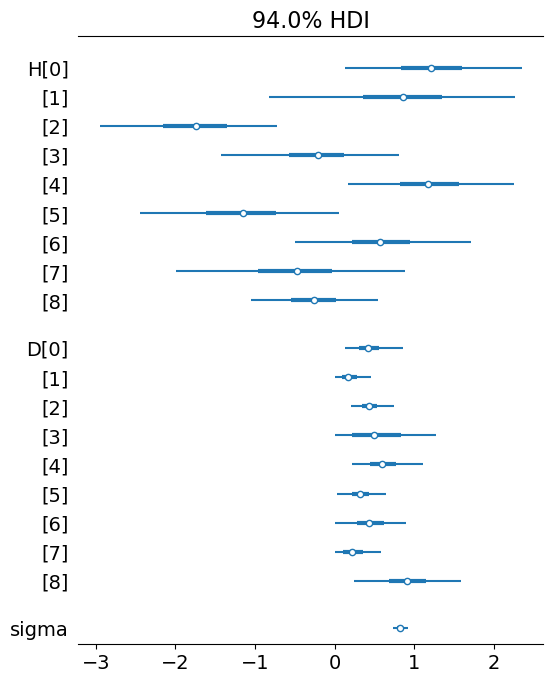

In [22]:
az.plot_forest(trace_3, var_names=("H", "D", "sigma"), combined=True)
plt.show()

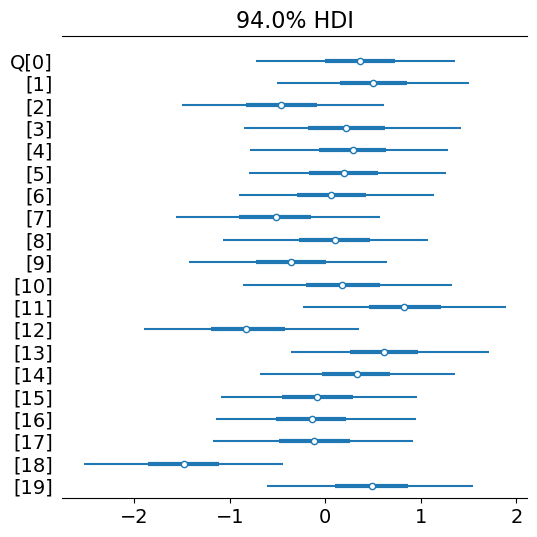

In [23]:
az.plot_forest(trace_3, var_names=("Q"), combined=True)
plt.show()

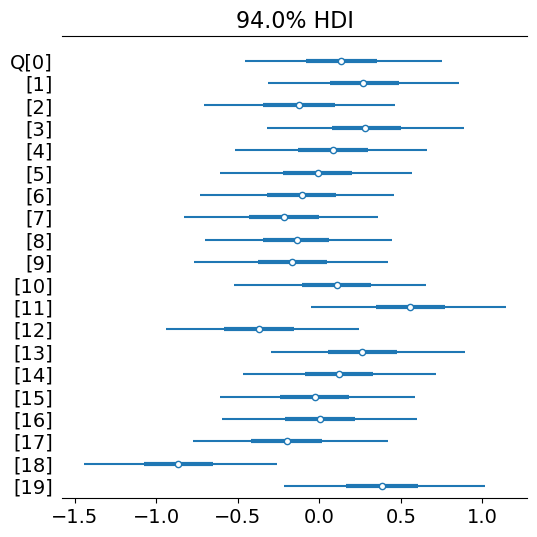

In [24]:
az.plot_forest(trace, var_names=("Q"), combined=True)
plt.show()

In [25]:
summary_wm3 = az.summary(trace_3, var_names=["dif_origen"])
summary_wm3 = summary_wm3[~summary_wm3.index.str.contains("lp__")]
summary_wm3 = summary_wm3[['mean', 'sd', 'hdi_3%', 'hdi_97%', 'r_hat', 'ess_bulk', 'ess_tail']]
summary_wm3.columns = ['mean', 'sd', 'q3', 'q97', 'rhat', 'ess_bulk', 'ess_tail']
summary_wm3 = summary_wm3.round(5)
print(summary_wm3)

             mean     sd     q3    q97  rhat  ess_bulk  ess_tail
dif_origen -0.308  0.498 -1.219  0.646   1.0    3757.0    5501.0


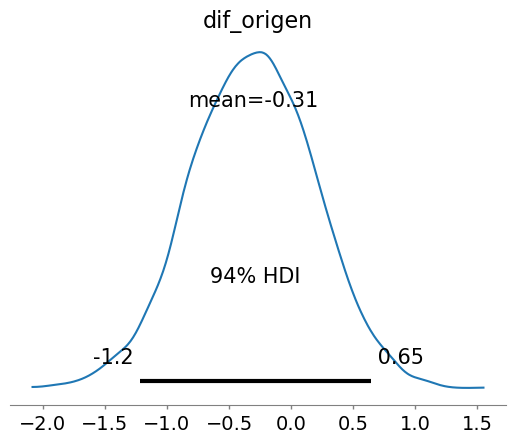

In [26]:
dif_origen_data = trace_3.posterior['dif_origen']
az.plot_posterior(dif_origen_data, bins='auto')
plt.show()

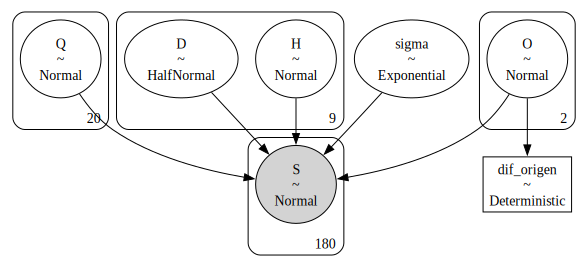

In [27]:
model_to_graphviz(wine_model_3)